# Inferentia 2 에서 HuggingFace에서 제공하는 ViT 돌리기
## 소개
출처: https://github.com/aws-neuron/aws-neuron-samples/blob/master/torch-neuronx/inference/hf_pretrained_vit_inference_on_inf2.ipynb

이 노트북은 Neuron에서 가속 추론을 위해 HuggingFace 🤗 Google Vision Transformer (ViT) 모델을 컴파일하고 실행하는 방법을 보여줍니다. 

이 노트북은 임의의 이미지 분류 작업에 주로 사용되는 google/vit-base-patch16-224 모델을 사용합니다.

이 Jupyter 노트북은 Inf2 또는 Trn1 인스턴스(inf2.xlarge 또는 trn1.2xlarge 이상)에서 실행되어야 합니다.

## 설치 가이드

In [1]:
%env TOKENIZERS_PARALLELISM=True #토크나이저 경고를 억제하여 오류 감지를 쉽게 함
!pip install -U transformers Pillow

env: TOKENIZERS_PARALLELISM=True #토크나이저 경고를 억제하여 오류 감지를 쉽게 함
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1


## 모델을 AWS Neuron 최적화된 TorchScript로 컴파일

다음 섹션에서는 모델과 특징 추출기를 로드하고, 샘플 입력을 가져오고, CPU에서 추론을 실행하고, torch_neuronx.trace()를 사용하여 Neuron용 모델을 컴파일하고, 최적화된 모델을 TorchScript로 저장합니다.

`torch_neuronx.trace()`는 추적에 사용할 텐서 또는 텐서 튜플 입력을 예상하므로, 특징 추출기 출력을 언팩합니다. 또한 컴파일 중에 사용되는 입력 형태는 추론 중에 사용되는 입력 형태와 일치해야 합니다. 이를 처리하기 위해 추론 중에 볼 최대 크기로 입력을 패딩합니다.

In [2]:
from PIL import Image
import requests
import torch
import torch_neuronx
from transformers import ViTImageProcessor, ViTForImageClassification
import matplotlib.pyplot as plt

# 특징 추출기와 모델 생성
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224') # ViT 모델의 입력 크기와 일치하는 특징 추출기 로드 사용
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', torchscript=True) # torchscript=True는 모델을 TorchScript로 변환하여 추론에 사용할 수 있도록 함
model.eval()

# 예제 입력 가져오기
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = feature_extractor(images=image, return_tensors="pt")
example = (inputs['pixel_values'],)

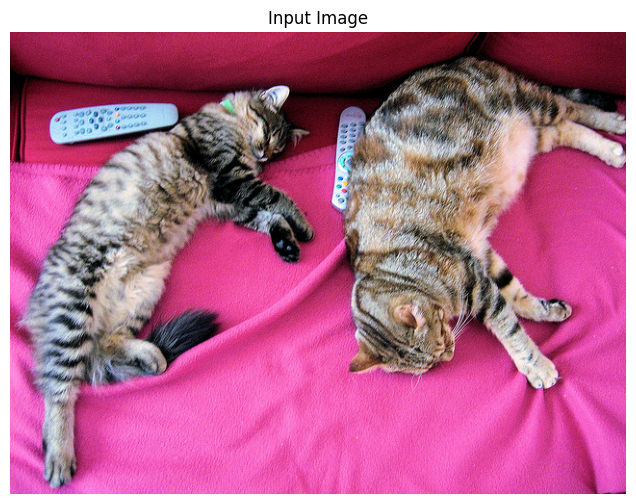

In [3]:
# 예시 이미지 출력
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title('Input Image')
plt.show()
image.save('cat.jpg', 'JPEG', quality=95)

In [4]:
# CPU에서 추론 실행
output_cpu = model(*example)

# 모델 컴파일
model_neuron = torch_neuronx.trace(model, example, compiler_args="--model-type=transformer")

# 추론 배포를 위한 TorchScript 저장
filename = 'model.pt'
torch.jit.save(model_neuron, filename)

..Completed run_backend_driver.

Compiler status PASS


## 추론 실행 및 결과 비교
컴파일된 모델을 로드하고, Neuron에서 추론을 실행하고, CPU와 Neuron 출력을 비교합니다.

In [5]:
model_neuron = torch.jit.load(filename)

# Neuron 모델을 사용하여 추론 실행
output_neuron = model_neuron(*example)

# 결과 비교
print(f"CPU 텐서:            {output_cpu[0][0][0:10]}")
print(f"Neuron 텐서:         {output_neuron[0][0][0:10]}")
print(f"CPU 분류:    {model.config.id2label[output_cpu[0].argmax(-1).item()]}")
print(f"Neuron 분류: {model.config.id2label[output_neuron[0].argmax(-1).item()]}")

CPU 텐서:            tensor([-0.2744,  0.8215, -0.0836,  0.4159,  0.5623,  0.1859, -0.5773, -0.4600,
        -0.5339,  0.2402], grad_fn=<SliceBackward0>)
Neuron 텐서:         tensor([-0.2768,  0.8239, -0.0802,  0.4104,  0.5620,  0.1778, -0.5776, -0.4596,
        -0.5370,  0.2475])
CPU 분류:    Egyptian cat
Neuron 분류: Egyptian cat
